
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Giant Hogweed Detection</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Names</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://lizzieharper.co.uk/wp-content/uploads/2023/03/Giant-Hogweed-Heracleum-mantegazzianum-lo-371x525.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

- Client: Sieuwe Elferink
- Instructors: Bob Tuinman, Pascal van den Bosch
- Date: 21-6-2024 

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Project</a></li>
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Loading Data</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 2: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 3: Model</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 4: Model evaluatie</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 5: Eigen data uittesten</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 6: API voor MRR</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 7: Bronnenlijst</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: Project </strong></h2>

</ul>

The giant hogweed is a plant that causes a lot of nuisance and if you touch it, you can get severe burns. This is due to the sap of the plant. The common hogweed, on the other hand, does not cause such problems and is much less dangerous. You can distinguish the giant hogweed from the common hogweed by its coarse, large leaves and rapid growth compared to the more modest, finer leaves of the common hogweed.

Our project faces several complications. One of the biggest challenges is the lack of available drone data, which is essential for training the model to detect the hogweed. Since we do not have this data available, we have to make our own drone recordings and then create masks for image recognition. This process is very time-consuming.

In addition, there are other challenges associated with obtaining this data. Flying drones requires specific permits and safety measures, especially in areas where the giant hogweed grows, which are often difficult to access.

Despite these challenges, we are determined to find solutions and make our project a success.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Loading data </strong></h2>

</ul>

**Packages**

In [1]:
import os
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import concatenate, UpSampling2D

**Own defined functions**

In [2]:
# Functie om maskers voor te verwerken om binaire waarden te garanderen
def preprocess_mask(mask):
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask

# Functie om pixels met 1 of 0 te tellen
def count_pixels(mask):
    unique, counts = np.unique(mask, return_counts=True)
    pixel_count = dict(zip(unique, counts))
    return pixel_count

# Functie om afbeeldingen weer te geven
def display_images(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Drempel toepassen op voorspelde maskers voor binaire segmentatie
def threshold_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(np.uint8)

In [3]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            if i + patch_h > h or j + patch_w > w:
                patch = patch[:h-i, :w-j, :]  # Adjust the patch size to fit the image dimensions
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

# Laad je eigen afbeelding
def load_single_image(image_path, target_size=None):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

In [4]:
def plot_loss(history):
    """
    Deze functie laat twee grafieken zien. De eerste toont de loss tijdens training en validatie over de epochs. 
    De tweede toont de IoU tijdens training en validatie over de epochs.

    Parameters:
        history: Dit is het object dat wordt teruggegeven door de `fit` methode van een Keras model.

    Returns:
        None
    """
    plt.figure(figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation Losses', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['loss'])), history.history['loss'], history.history['val_loss'], color='lightgray', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['IoU'], label='Training IoU', color='#1f77b4', linestyle='-', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_IoU'], label='Validation IoU', color='#ff7f0e', linestyle='--', linewidth=2, alpha=0.8)
    plt.title('Training and Validation IoU', fontdict={'fontsize': 18, 'fontweight': 'bold', 'color': '#333333'})
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('IoU', fontsize=14)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
    plt.fill_between(range(len(history.history['IoU'])), history.history['IoU'], history.history['val_IoU'], color='lightgray', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [5]:
def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [6]:
# Functie om alleen de input en de voorspelde maskers weer te geven
def display_prediction_images(input_image, predicted_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.preprocessing.image.array_to_img(input_image))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

#### Hier knippen we de data op in allemaal kleine afbeeldingen van 256x256, zodat we meer data beschikbaar hebben en de foto's niet te groot zijn om inteladen

```python


def split_and_save_images(image_dir, output_dir, patch_size=256):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_names = os.listdir(image_dir)

    for file_name in file_names:
        image_path = os.path.join(image_dir, file_name)
        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            num_patches_x = width // patch_size
            num_patches_y = height // patch_size

            for i in range(num_patches_x):
                for j in range(num_patches_y):
                    left = i * patch_size
                    upper = j * patch_size
                    right = (i + 1) * patch_size
                    lower = (j + 1) * patch_size
                    
                    patch = image.crop((left, upper, right, lower))
                    patch_name = f"{file_name.split('.')[0]}_patch_{i}_{j}.jpg"
                    patch.save(os.path.join(output_dir, patch_name))

image_dir = 'eigen masks/images'
output_dir = 'eigen masks/image_patches'
split_and_save_images(image_dir, output_dir)

mask_dir = 'eigen masks/masks'
output_dir = 'eigen masks/mask_patches'
split_and_save_images(mask_dir, output_dir)

**Loading images & masks**

Total images: 8802
Steps per epoch: 137
Validation steps: 27.0


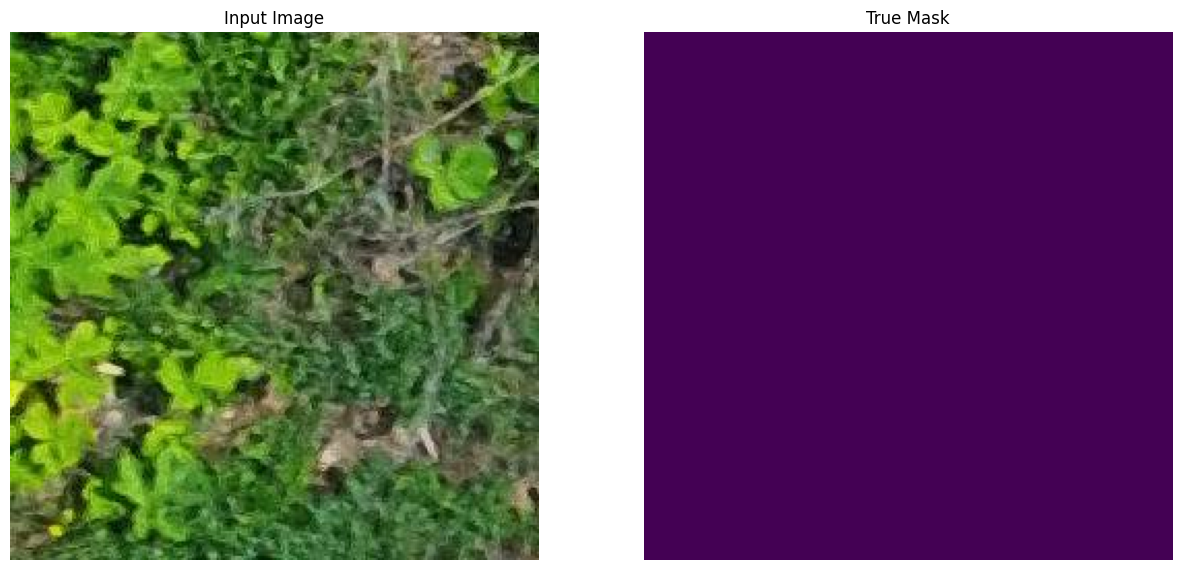

In [8]:
def batch_generator(image_folder, mask_folder, batch_size):
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)
    while True:
        batch_images = []
        batch_masks = []
        for i in range(batch_size):
            img_file = image_files[i % len(image_files)]
            mask_file = mask_files[i % len(mask_files)]
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)

            image = load_img(img_path, target_size=(256, 256))
            mask = load_img(mask_path, target_size=(256, 256), color_mode="grayscale")

            image = img_to_array(image) / 255.0
            mask = img_to_array(mask)
            mask = preprocess_mask(mask)

            batch_images.append(image)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)

image_folder = 'self-labeled data/image_patches'
mask_folder = 'self-labeled data/mask_patches'
batch_size = 64
total_images = len(os.listdir(image_folder))
total_masks = len(os.listdir(mask_folder))

# Bereken steps_per_epoch en validation_steps
steps_per_epoch = total_images // batch_size
validation_steps = (total_images * 0.2) // batch_size

print(f"Total images: {total_images}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

generator = batch_generator(image_folder, mask_folder, batch_size=batch_size)
batch_images, batch_masks = next(generator)
train_images, test_images, train_masks, test_masks = train_test_split(batch_images, batch_masks, test_size=0.2, random_state=42)

# Voorbeeldweergave van een afbeelding en masker
sample_image, sample_mask = train_images[17], train_masks[17]
display_list = [sample_image, sample_mask]
display_images(display_list)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Exploratory Data Analysis </strong></h2>
</div>

In [9]:
num_images_without_masks = sum(np.all(mask == 0) for mask in train_masks)
percentage_without_masks = num_images_without_masks / len(train_masks) * 100

print(f"Aantal afbeeldingen in de dataset: {len(train_masks)}")
print(f"Aantal afbeeldingen met maskers: {len(train_masks) - num_images_without_masks}")
print(f"Aantal afbeeldingen zonder maskers: {num_images_without_masks}")
print(f"Percentage afbeeldingen met maskers: {100 - round(percentage_without_masks, 2)}%")
print(f"Percentage afbeeldingen zonder maskers: {round(percentage_without_masks, 2)}%")

Aantal afbeeldingen in de dataset: 51
Aantal afbeeldingen met maskers: 6
Aantal afbeeldingen zonder maskers: 45
Percentage afbeeldingen met maskers: 11.760000000000005%
Percentage afbeeldingen zonder maskers: 88.24%


In [10]:
print(f"Afbeelding lengte en breedte: {images[0].shape}")

NameError: name 'images' is not defined

In [11]:
data = []

for i in range(len(images)):
    height, width, channels = images[i].shape
    size = height * width
    has_mask = np.any(masks[i])
    mask_coverage = np.sum(masks[i]) / size
    aspect_ratio = width / height
    avg_color = np.mean(images[i], axis=(0, 1)) / 255  
    avg_color_hex = mcolors.rgb2hex(avg_color)
    
    color_std = np.std(images[i], axis=(0, 1)) / 255
    brightness = np.mean(images[i]) / 255
    gray_image = rgb2gray(images[i])
    contrast = np.std(gray_image)

    data.append([i, width, height, size, has_mask, mask_coverage, avg_color, avg_color_hex, color_std, brightness, contrast])

images_info = pd.DataFrame(data, columns=['image_id', 'Breedte', 'Hoogte', 'Grootte'
                                          , 'Heeft een mask', 'Mask bedekking', 'Verdeling kleuren'
                                          , 'Gemiddelde kleur HTML', 'Kleurvariatie', 'Helderheid'
                                          , 'Contrast'])

images_info.head(10)

NameError: name 'images' is not defined

 1.⁠ ⁠⁠ image_id ⁠: Dit is een unieke identificatie voor elke afbeelding in de dataset. In dit geval is het de index van de afbeelding in de lijst ⁠ images ⁠. Bijvoorbeeld, ⁠ 0 ⁠ betekent dat dit de eerste afbeelding in de lijst is. Het is belangrijk om elke afbeelding te kunnen identificeren, vooral als je later naar specifieke afbeeldingen wilt verwijzen.

 2.⁠ ⁠⁠ Breedte ⁠: Dit is de breedte van de afbeelding in pixels. In dit geval is de breedte ⁠ 224 ⁠ pixels. Het kennen van de afmetingen van de afbeelding kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 3.⁠ ⁠⁠ Hoogte ⁠: Dit is de hoogte van de afbeelding in pixels. In dit geval is de hoogte ⁠ 224 ⁠ pixels. Net als de breedte kan de hoogte nuttig zijn bij het analyseren van de afbeelding.

 4.⁠ ⁠⁠ Grootte ⁠: Dit is het totale aantal pixels in de afbeelding, berekend als breedte x hoogte. In dit geval is de grootte ⁠ 50176 ⁠ pixels. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

 5.⁠ ⁠⁠ Heeft een mask ⁠: Dit geeft aan of de afbeelding een bijbehorend masker heeft. In dit geval heeft de afbeelding geen masker (⁠ False ⁠). Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de aanwezigheid van een masker de andere kenmerken van de afbeelding beïnvloedt.

 6.⁠ ⁠⁠ Mask bedekking ⁠: Dit is het percentage van de afbeelding dat wordt bedekt door het masker, berekend als het aantal maskerpixels gedeeld door het totale aantal pixels. In dit geval is de maskerdekking ⁠ 0.000000 ⁠, wat betekent dat er geen masker is. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de maskerdekking de andere kenmerken van de afbeelding beïnvloedt.

 7.⁠ ⁠⁠ Verdeling kleuren ⁠: Dit is de gemiddelde kleur van de afbeelding, berekend als de gemiddelde RGB-waarde van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de gemiddelde kleur ⁠ [0.3177765, 0.31320137, 0.20988709] ⁠, wat een donkerbruine kleur is. Het kennen van de gemiddelde kleur kan nuttig zijn bij het analyseren van de afbeelding, zodat je weet hoe verschillend de kleuren zijn.

 8.⁠ ⁠⁠ Gemiddelde kleur HTML ⁠: Dit is de gemiddelde kleur van de afbeelding, omgezet naar een HTML-kleur (hexadecimale kleurcode). In dit geval is de gemiddelde kleur ⁠ #515036 ⁠, wat overeenkomt met de RGB-kleur in de 'Verdeling kleuren' kolom. Het kennen van de HTML-kleur kan nuttig zijn voor visualisatiedoeleinden, bijvoorbeeld om een overzicht van de gemiddelde kleuren van de afbeeldingen te maken.

 9.⁠ ⁠⁠ Kleurvariatie ⁠: Dit is de standaardafwijking van de kleuren in de afbeelding, berekend als de standaardafwijking van de RGB-waarden van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de kleurvariatie ⁠ [0.18607375, 0.18607375, 0.18607375] ⁠, wat betekent dat de kleuren in de afbeelding niet erg variëren. Het kennen van de kleurvariatie kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe uniform de kleuren zijn.

10.⁠ ⁠⁠ Helderheid ⁠: Dit is de gemiddelde helderheid van de afbeelding, berekend als de gemiddelde helderheid van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de helderheid ⁠ 0.31320137 ⁠, wat betekent dat de afbeelding niet erg helder is. Het kennen van de helderheid kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe licht of donker de afbeelding is.

11.⁠ ⁠⁠ Contrast ⁠: Dit is de contrastwaarde van de afbeelding, berekend als de standaardafwijking van de grijswaarden van de afbeelding. In dit geval is het contrast ⁠ 0.18607375 ⁠, wat betekent dat de afbeelding een gemiddeld contrast heeft. Het kennen van het contrast kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe scherp de overgangen tussen lichte en donkere delen zijn.

In [12]:
images_info[['Kleurvariatie', 'Helderheid', 'Contrast']].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

NameError: name 'images_info' is not defined

In [ ]:
plt.hist(images_info['Mask bedekking'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Count')
plt.title('Distribution of mask coverage')
plt.show()

We zien dat er veel afbeeldingen zijn zonder of weinig maskers. Dit is dan moeilijk voor het model om te leren. 
Wel is dit nodig, omdat we kunnen zien dat het model ook werkt als er geen berenklauw te zien is. 
Zoals eerder is aangegeven is 17% van de afbeeldingen zonder masker. Dit is een prima percentage om mee te werken, omdat het model ook moet leren om afbeeldingen zonder masker te herkennen meestal afbeeldingen zijn zonder berenklauwen.

**Data Augmentation**

In [ ]:
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(train_images, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(train_masks, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Different Models </strong></h2>
</div>

### **Literature Review and Models**
For our task of detecting giant hogweed through pixel segmentation, it is important to use models that can segment accurately and in detail. Based on literature studies, we have made a good selection of deep learning models to achieve the best results for our task. These models are specifically designed for pixel segmentation tasks. Below, we have summarized what the papers consider to be the best models.




**Paper: "Comparison of Deep-Learning-Based Segmentation Models: Using Top View Person Images" by Imran Ahmed, Misbah Ahmad, Fakhri Alam Khan, and Muhammad Asif**

- U-Net:
    - Architecture: U-Net has an encoder-decoder structure with symmetric connections between the downsampling and upsampling paths, helping to retain detailed spatial information.
    - Performance: The model provides high accuracy in segmentation tasks by utilizing low- and high-resolution features.

- DeepLabV3:
    - Architecture: DeepLabV3 uses atrous convolutions to preserve high-resolution features without significantly increasing computational time. It uses ResNet-101 as a base and integrates parallel and consecutive modules of atrous convolutions.
    - Performance: DeepLabV3 outperforms many other models in terms of accuracy and preserving detailed objects. The model provides good results even in complex images and different lighting conditions.

- Fully Convolutional Network (FCN):
    - Architecture: FCN replaces fully connected layers with convolutional layers, allowing for dense pixel predictions. The model uses upsampling to generate output of the same size as the input.
    - Performance: FCN is often used as a baseline for other segmentation models due to its robust and good segmentation results. Although it may not always offer the highest accuracy, it is fast and effective for many applications.


**Paper: "Understanding Deep Learning Techniques for Image Segmentation" by Swarnendu Ghosh, Nibaran Das, Ishita Das, and Ujjwal Maulik**

- Deep Layer Cascade:
    - Why Good? This model operates in multiple stages where easily segmented areas are segmented immediately, and more difficult areas in later stages. This approach improves the speed and accuracy of segmentation.
    - Performance: Achieves an average Intersection over Union (IoU) of 82.7 on the VOC12 test set.

- DeepLab:
    - Why Good? DeepLab uses dilated convolutions, meaning the filter is expanded by skipping intermediate pixels during the operation (atrous), and fully connected conditional random fields (CRFs) to enhance contextual information without losing segmentation resolution, resulting in sharper segmentation output.
    - Performance: Achieves an average IoU of 79.7 on the PASCAL VOC 2012 dataset.

- PSPNet (Pyramid Scene Parsing Network):
    - Why Good? This model utilizes spatial pyramid pooling to leverage features at different scales, aiding in segmenting objects of different sizes in real environments.
    - Performance: Scores an average IoU of 57.21 on the ImageNet Scene Parsing Challenge.



**Paper: "A Review on Deep Learning Techniques Applied to Semantic Segmentation" by A. Garcia-Garcia, S. Orts-Escolano, S.O. Oprea, V. Villena-Martinez, and J. Garcia-Rodriguez**

- Fully Convolutional Networks (FCNs):
    - Description: FCNs have transformed traditional convolutional neural networks (CNNs) by replacing fully connected layers with convolutional layers that provide spatial maps instead of classification scores.
    - Reason for Success: This model can be trained end-to-end for semantic segmentation, enabling efficient and accurate predictions for each pixel. FCNs have demonstrated significant improvements in segmentation accuracy on datasets such as PASCAL VOC.

- DeepLab:
    - Description: DeepLab utilizes atrous convolutions, spatial pooling pyramids, and fully connected conditional random fields (CRFs).
    - Reason for Success: Atrous convolutions expand the field of view without increasing the number of parameters, helping to capture information without reducing segmentation sharpness. DeepLab achieved a high mean IoU of 79.7 on the PASCAL VOC 2012 dataset.

- DAG-RNN (Directed Acyclic Graph Recurrent Neural Network):
    - Description: This model uses a directed graph structure to model contextual information.
    - Reason for Success: DAG-RNN has achieved high accuracy on datasets such as CamVid (91.60 IoU) through context modeling.









### **Selected Models for Our Application**

Based on the mentioned papers and the specific requirements for detecting giant hogweed, we have selected the following models that we will use.

- U-Net:

    - Reason for Choice: The encoder-decoder architecture with connections provides detailed segmentation and retains spatial information, crucial for the accurate detection of giant hogweed.

- DeepLab (DeepLabV3):

    - Reason for Choice: The application of atrous convolutions and conditional random fields provides sharp segmentation output and effective information processing, which is particularly useful in complex images.

- Fully Convolutional Network (FCN):

    - Reason for Choice: As a fast and robust model, FCN offers a good balance between speed and accuracy, which is important for real-time applications.

With these models, we aim to achieve optimal performance in detecting and segmenting giant hogweed in images, enabling us to obtain accurate location information for further analysis.


### **U-net**

In [18]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[IoU])
    
    return model

model = unet_model()
model.summary()

NameError: name 'IoU' is not defined

### **DeepLab**

### **Fully Convolutional Network (FCN)**

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Using own data on trained models </strong></h2>
</div>

In [ ]:
def split_image(image, patch_size=256):
    patches = []
    h, w, _ = image.shape
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_h = patch_size - patch.shape[0]
                pad_w = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
            patches.append(patch)
    return patches

def merge_patches(patches, image_shape, patch_size=256):
    h, w, c = image_shape
    reconstructed_image = np.zeros((h, w, 1))
    patch_index = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = patches[patch_index]
            patch_h, patch_w, _ = patch.shape
            reconstructed_image[i:i+patch_h, j:j+patch_w, :] = patch
            patch_index += 1
    return reconstructed_image

# Laad je eigen afbeelding
def load_single_image(image_path, target_size=(256, 256)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image) / 255.0
    return image

# Geef het pad van je eigen afbeelding
own_image_path = 'eigen data/your_image.jpg'
own_image = load_single_image(own_image_path, target_size=None)  # Load original size

# Snijd de afbeelding in stukken van 256x256
patches = split_image(own_image, patch_size=256)

# Voer voorspellingen uit voor elk stuk
patches_array = np.array(patches)
pred_patches = model.predict(patches_array)
pred_patches_thresholded = threshold_predictions(pred_patches, threshold=0.5)

# Voeg de voorspelde stukken samen tot één volledige afbeelding
reconstructed_mask = merge_patches(pred_patches_thresholded, own_image.shape, patch_size=256)

# Toon de resultaten
display_prediction_images(own_image, reconstructed_mask)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=3, validation_data=(test_images, test_masks), validation_steps=validation_steps)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: Best Model </strong></h2>
</div>

In [ ]:
pred_masks = model.predict(test_images)
pred_masks_thresholded = threshold_predictions(pred_masks, threshold=0.5)

for i in range(len(test_images)):
    display_images([test_images[i], test_masks[i], pred_masks_thresholded[i]])

In [ ]:
plot_loss(history)